In [1]:
import os
print(os.listdir("/kaggle/input/alzheimer-disease-dataset/Alzheimer_Dataset_V2"))



['val', 'test', 'train']


In [2]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
import seaborn as sns




2025-08-18 07:29:16.070513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755502156.273872      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755502156.334119      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir=r"/kaggle/input/alzheimer-disease-dataset/Alzheimer_Dataset_V2"

img_size=(224,224)
batch_size=32

def compute_class_weights(dataset, n_classes):
    counts = np.zeros(n_classes, dtype=np.int64)  # مصفوفة لحساب عدد الصور في كل كلاس
    for _, y in dataset.unbatch():  # نفكّ الـ batch ونعدّ الصور
        counts[y.numpy()] += 1
    total = counts.sum()  # العدد الكلي للصور
    weights = {i: float(total) / (n_classes * counts[i]) for i in range(n_classes)}  # نحسب الوزن
    return counts, weights


num_classes = 4

train_ds=tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, "train"),
        labels="inferred", 
        label_mode="int", 
        image_size=img_size, 
        batch_size=batch_size, 
        shuffle=True
    )




val_ds=tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, "val"),
        labels="inferred", 
        label_mode="int", 
        image_size=img_size, 
        batch_size=batch_size, 
        shuffle=False)


test_ds=tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_dir, "test"),
        labels="inferred", 
        label_mode="int", 
        image_size=img_size, 
        batch_size=batch_size, 
        shuffle=False)


train_counts, class_weight = compute_class_weights(
    train_ds,
    num_classes)

# طباعة النتائج
print("Train counts per class:", dict(zip("train", train_counts)))
print("Class weights:", class_weight)


Found 23788 files belonging to 4 classes.


I0000 00:00:1755502196.273766      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 5097 files belonging to 4 classes.
Found 5099 files belonging to 4 classes.
Train counts per class: {'t': 6272, 'r': 4524, 'a': 6720, 'i': 6272}
Class weights: {0: 0.9481823979591837, 1: 1.3145446507515473, 2: 0.8849702380952381, 3: 0.9481823979591837}


In [4]:
model=models.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(64,(5,5),activation='relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(5,5),activation='relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    #layers.Conv2D(256,(5,5),activation='relu',padding='same'),
    #layers.MaxPooling2D((2,2)),
    

    layers.GlobalAveragePooling2D(),

    layers.Dense(64,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(4,activation='softmax')
]
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,556 (1.02 MB)

 Trainable params: 267,556 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
Check_point=ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor='val_loss'
    
)
early_stopping=EarlyStopping(
    patience=6,
    restore_best_weights=True,
    monitor='val_loss'
)


In [6]:
model.compile(
    optimizer="adam",                
    loss="sparse_categorical_crossentropy",   
    metrics=["accuracy"]              # علشان يطلع الدقة
)


In [7]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight,
    callbacks=[Check_point,early_stopping]
)

Epoch 1/30


I0000 00:00:1755502262.070584      65 service.cc:148] XLA service 0x7c9b5c00d670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755502262.071367      65 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755502262.500159      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/744 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.2064 - loss: 1.4273

I0000 00:00:1755502266.275284      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


744/744 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.2733 - loss: 1.3564 - val_accuracy: 0.4952 - val_loss: 1.1125
Epoch 2/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5197 - loss: 1.0321 - val_accuracy: 0.6115 - val_loss: 0.8260
Epoch 3/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.6172 - loss: 0.7802 - val_accuracy: 0.6247 - val_loss: 0.7760
Epoch 4/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.6483 - loss: 0.6952 - val_accuracy: 0.6582 - val_loss: 0.7155
Epoch 5/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.6746 - loss: 0.6430 - val_accuracy: 0.6943 - val_loss: 0.6446
Epoch 6/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.7018 - loss: 0.5939 - val_accuracy: 0.7081 - val_loss: 0.6393
Epoch 7/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.7211 - loss: 0.5608 - val_accuracy: 0.7479 - val_loss: 0.5497
Epoch 8/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.7471 - loss: 0.5166 - val_accurac

In [8]:
model.save("alz_model.h5")


In [9]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


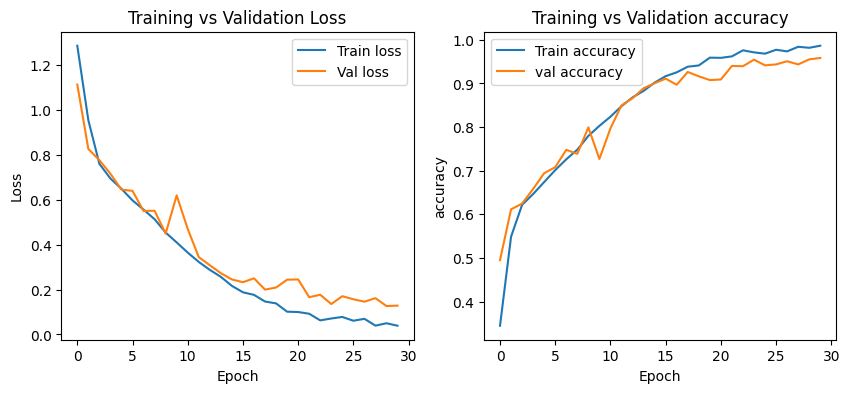

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Val loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Training vs Validation Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Train accuracy')
plt.plot(history.history['val_accuracy'],label='val accuracy')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title('Training vs Validation accuracy')
plt.show()

160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9679 - loss: 0.1095
Test Loss: 0.13349387049674988
Test Accuracy: 0.9586193561553955
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
                  precision    recall  f1-score   support

    MildDemented       0.97      0.97      0.97      1344
ModerateDemented       1.00      1.00      1.00       971
     NonDemented       0.98      0.91      0.95      1440
VeryMildDemented       0.90      0.97      0.93      1344

        accuracy                           0.96      5099
       macro avg       0.96      0.96      0.96      5099
    weighted avg       0.96      0.96      0.96      5099



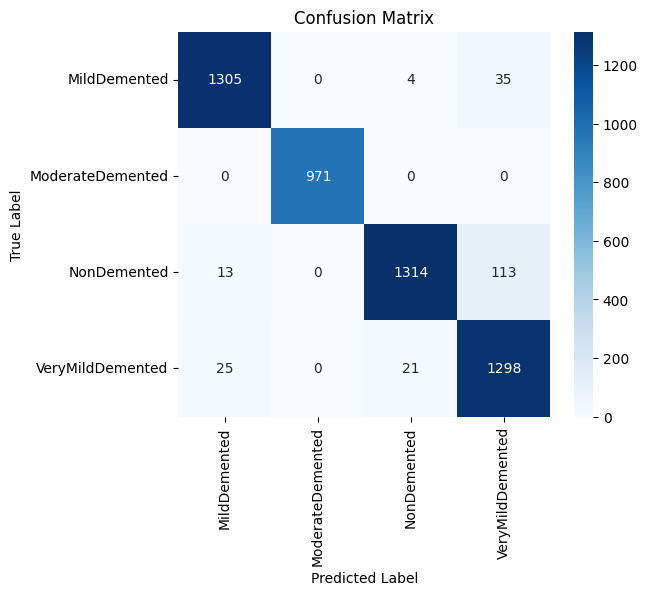

In [11]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

class_names = train_ds.class_names

# القيم الحقيقية
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# القيم المتوقعة
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# تقرير الأداء
print(classification_report(y_true, y_pred_classes, target_names=class_names))



cm = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [12]:
/kaggle/working/best_model.h5

NameError: name 'kaggle' is not defined